# Pokemon Type Prediction

In this project, I will try to predict a Pokemon's type through its combat values (attack, defense, speed, etc.). I will experiment with different machine learning classification models such as decision trees and k nearest neighbors. We will use 6 features to build our models: HP (hit points), Attack, Defense, Sp. Attack, Sp. Defense, and Speed. To keep things simple, we will only try to predict a Pokemon's first type for those that have two types. The data will be randomly split into an 80 percent training set and a 20 percent test set (hold-out validation).

The dataset can be found here: https://www.kaggle.com/datasets/abcsds/pokemon?resource=download

Load required packages.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Load the data in.

In [2]:
pokemon_df = pd.read_csv('Pokemon.csv')
pokemon_df.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


## Part 1: Data Cleaning

Drop the columns that will not be used (number, generation, legendary).

In [3]:
pokemon_df = pokemon_df.drop(['#', 'Generation', 'Legendary'], axis=1)
pokemon_df.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80
3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80
4,Charmander,Fire,NaN,309,39,52,43,60,50,65


Remove mega versions of pokemon because we do not want duplicates and want to look at a Pokemon's base attributes rather than a stronger version.

In [4]:
mega = pokemon_df.index[pokemon_df['Name'].str.contains('Mega')].tolist() # get indices of mega pokemon
pokemon_df = pokemon_df.drop(index=mega)
pokemon_df.head()

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80
4,Charmander,Fire,NaN,309,39,52,43,60,50,65
5,Charmeleon,Fire,NaN,405,58,64,58,80,65,80


In [5]:
pokemon_df.shape

(751, 10)

Let's now analyze these 751 Pokemon.

## Part 2: EDA

How many different types of Pokemon are there?

In [6]:
print(pd.unique(pokemon_df['Type 1']))
print(len(pd.unique(pokemon_df['Type 1'])))

['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Poison' 'Electric' 'Ground'
 'Fairy' 'Fighting' 'Psychic' 'Rock' 'Ghost' 'Ice' 'Dragon' 'Dark' 'Steel'
 'Flying']
18


There are 18 unique types of Pokemon in the dataset.

How many Pokemon of each type are there?

Water       107
Normal       94
Grass        66
Bug          65
Psychic      52
Fire         48
Electric     42
Rock         41
Ground       32
Ghost        30
Poison       28
Dark         28
Dragon       26
Fighting     25
Ice          23
Steel        23
Fairy        17
Flying        4
Name: Type 1, dtype: int64


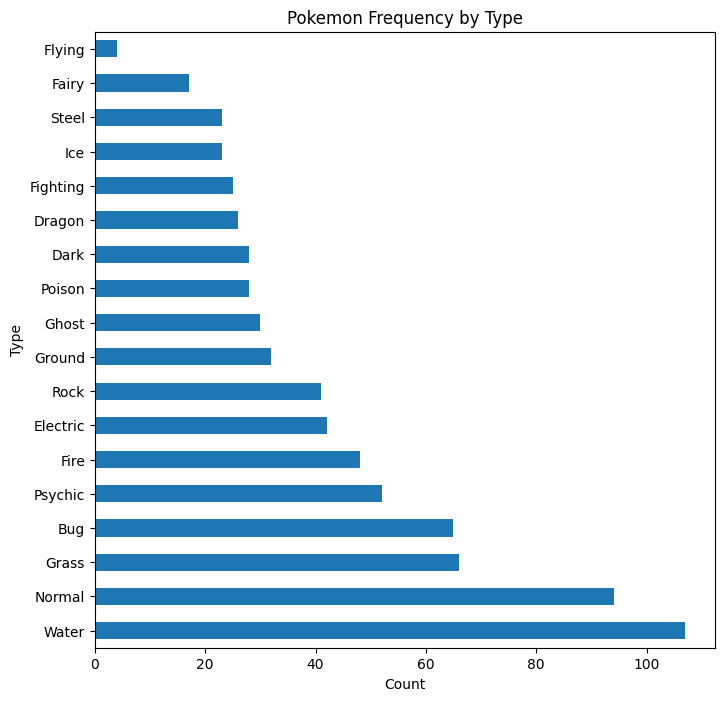

In [7]:
counts = pd.value_counts(pokemon_df['Type 1'])
print(counts)
plt.figure(figsize=(8,8))
counts.plot.barh()
plt.title('Pokemon Frequency by Type')
plt.xlabel('Count')
plt.ylabel('Type')
plt.show()

Pie Chart:

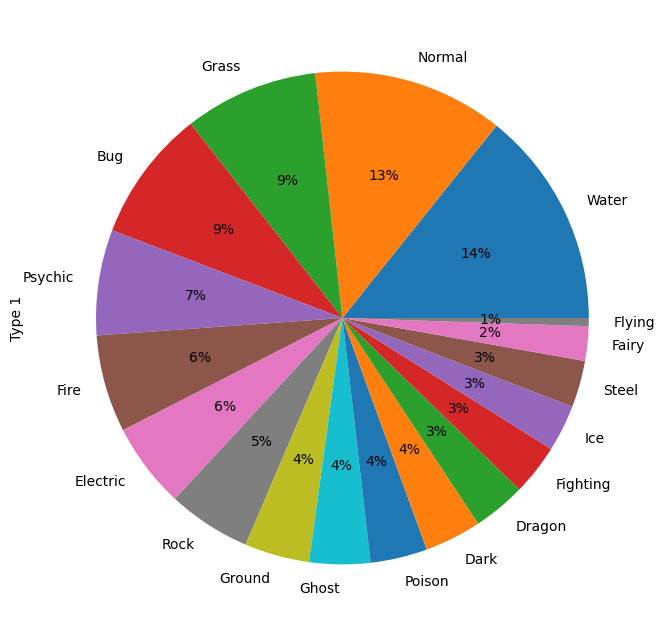

In [8]:
labels = pokemon_df['Type 1'].value_counts().index
pokemon_df['Type 1'].value_counts().plot(kind='pie', labels=labels, autopct='%1.0f%%', figsize=(8,8))
plt.show()

Water and normal appear to be the most common types. Classification may not be as accurate for some of the less common types in the dataset (i.e. Fairy, Flying). Especially for flying types, since there are only 4 Pokemon, it would probably be best to not include them in the prediction.

In [9]:
pokemon_df = pokemon_df[pokemon_df['Type 1'] != 'Flying']
print(len(pokemon_df))

747


# Part 3: Classification

## Classification Method 1: Decision Tree

Filter the data into numerical and target values.

In [10]:
stats = pokemon_df.iloc[:, 4:]
target = pokemon_df['Type 1']

Split the data into a training and testing set.

In [11]:
from sklearn.model_selection import train_test_split

stats_train, stats_test, target_train, target_test = train_test_split(stats, target, test_size=0.2, random_state=13) # 42

Training Set:

In [12]:
stats_train.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
501,40,50,90,30,55,65
672,66,117,70,40,50,67
35,70,62,67,55,55,56
46,40,45,35,30,40,55
84,65,100,70,80,80,105


In [13]:
target_train.head()

501    Poison
672    Dragon
35     Poison
46     Poison
84       Fire
Name: Type 1, dtype: object

In [14]:
print('Training Set:', len(stats_train))
print('Testing Set:', len(stats_test))

Training Set: 597
Testing Set: 150


So the training set has 597 pokemon and the testing set has 150. Let's make sure that the training set has pokemon of every type so that it is possible for every type to be predicted.

In [15]:
print(pd.unique(target_train))
print(len(pd.unique(target_train)))

['Poison' 'Dragon' 'Fire' 'Electric' 'Normal' 'Fighting' 'Psychic' 'Water'
 'Steel' 'Dark' 'Bug' 'Grass' 'Rock' 'Ghost' 'Fairy' 'Ice' 'Ground']
17


All 17 types are included in the training set.

## Model Training

I have chosen to use the default hyper-parameters provided by DecisionTreeClassifier because trying different parameters such as using "random" instead of "best" split and reducing the max_depth resulted in lower accuracy scores for the testing set. I also chose the arbitrary random_state of 42 in order to get consistent, reproducible results.

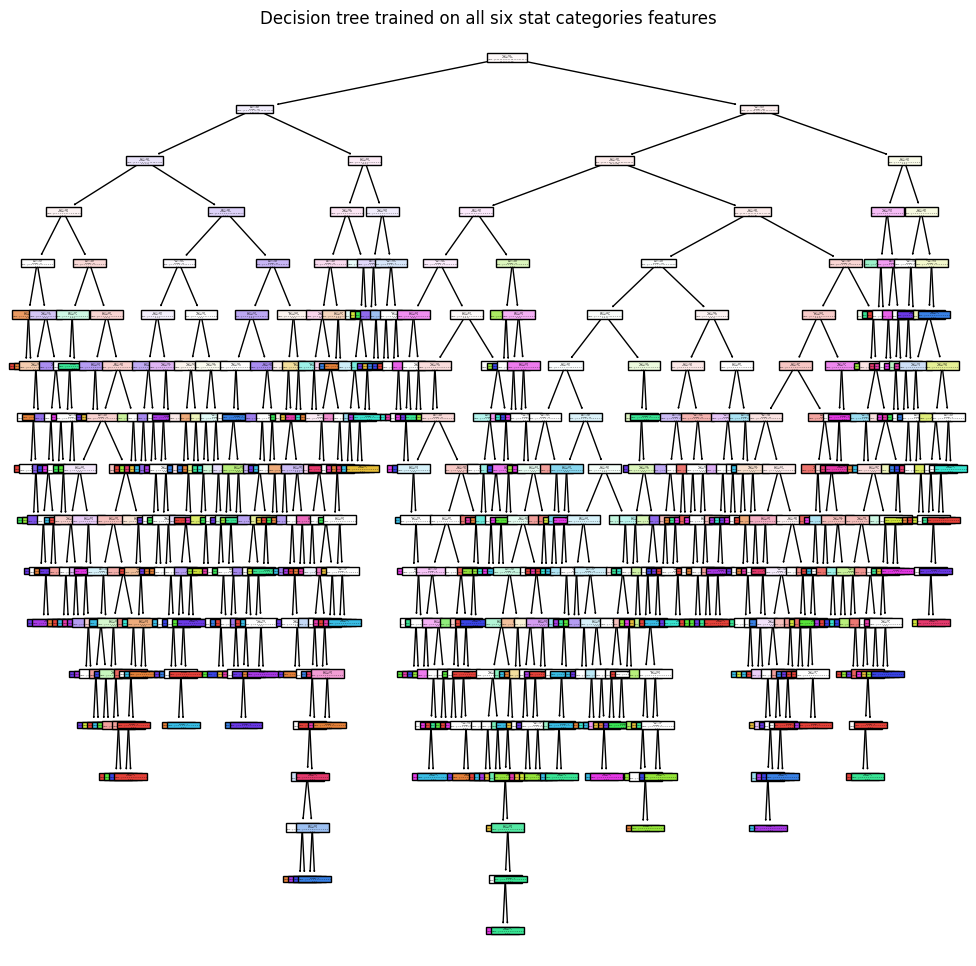

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

plt.figure(figsize=(12,12))
clf = DecisionTreeClassifier(random_state=13).fit(stats_train, target_train)
plot_tree(clf, filled=True)
plt.title("Decision tree trained on all six stat categories features")
plt.show()

In [17]:
print(clf.tree_.max_depth)

17


The decision tree has a max depth of 17.

## Model Evaluation

We will use the accuracy metric to evaluate the performance of the model (i.e. percent of predictions that are correct).

Accuracy of tree for training set:

In [18]:
clf.score(stats_train, target_train)

0.9849246231155779

The prediction accuracy for the training set is very high, indicating that over-fitting may have occurred.

Accuracy of tree for testing set:

In [19]:
clf.score(stats_test, target_test)

0.16

The model is only 16 percent accurate for the testing set. Note this is better than random guessing (1/17 = 0.0588).

Let's look at the first 5 predictions made by the model for the testing set:

In [20]:
clf.predict(stats_test)[0:5]

array(['Normal', 'Ground', 'Ghost', 'Steel', 'Fighting'], dtype=object)

Versus the actual types:

In [21]:
target_test.head()

441      Normal
72     Fighting
620        Dark
147        Fire
658       Grass
Name: Type 1, dtype: object

We have seen that using a DecisionTreeClassifier does not produce very accurate predictions. Let us now try a different approach.

## Classification Method 2: kNN Classification

The decision tree may not have been that effective because it was forced to rank the features based on importance when all the features may be equally important in determining a Pokemon's primary type. We will now try using the k nearest neighbors algorithm instead. To compare the performances of these two models, we will use the same training and test set as the previous method.

To choose a value for k (number of neighbors), let's experiment with various values of k and observe how accurate the model's predictions are on the testing and training sets.

Create lists of accuracy scores ranging from k=1 to k= 30 for the training and testing sets.

In [22]:
from sklearn.neighbors import KNeighborsClassifier

train_scores = []
test_scores = []
for k in range(30):
    knn = KNeighborsClassifier(n_neighbors = k+1)
    knn.fit(stats_train, target_train)
    train_scores.append(knn.score(stats_train, target_train))
    test_scores.append(knn.score(stats_test, target_test))

Plot these values

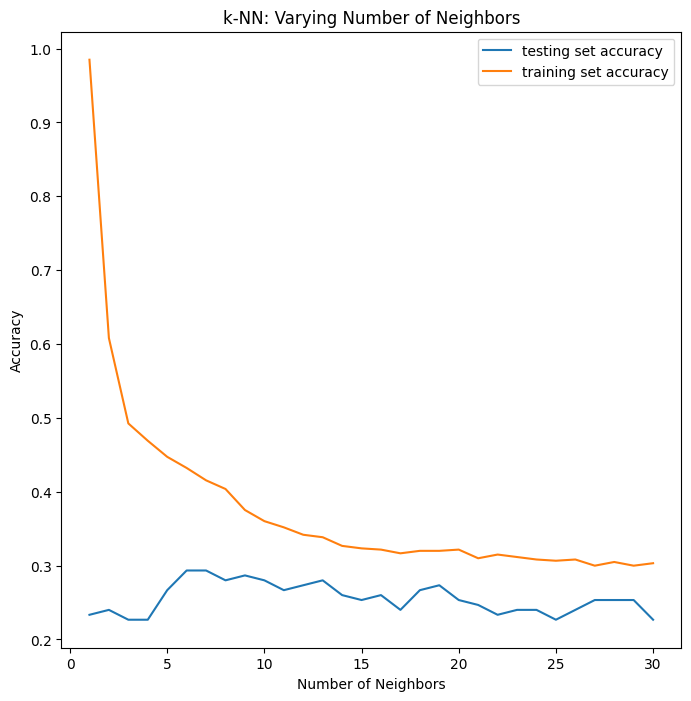

In [23]:
import numpy as np

num_neighbors = np.arange(1,31)
plt.figure(figsize=(8,8))
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(num_neighbors, test_scores, label='testing set accuracy')
plt.plot(num_neighbors, train_scores, label='training set accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

The highest accuracy score for the testing set appears to occur around the k = 6-7 range.

In [25]:
print('Max Accuracy:', max(test_scores))
print('Number of Neighbors:', test_scores.index(max(test_scores)) + 1)

Max Accuracy: 0.29333333333333333
Number of Neighbors: 6


The highest accuracy score on the testing set appears to be when there are k = 6 neighbors. Let's use this as our choice for k.

In [26]:
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 13)
# Fit the classifier to the data
knn.fit(stats_train, target_train)

KNeighborsClassifier(n_neighbors=13)

Show first 5 model predictions on the test data.

In [27]:
knn.predict(stats_test)[0:5]

array(['Normal', 'Ground', 'Ghost', 'Fire', 'Rock'], dtype=object)

Versus the actual types:

In [28]:
target_test.head()

441      Normal
72     Fighting
620        Dark
147        Fire
658       Grass
Name: Type 1, dtype: object

Unlike the DecisionTreeClassifier, this model correctly predicted two of the first five test samples.

Let's see how accurate this model is for the training set:

In [29]:
knn.score(stats_train, target_train)

0.33835845896147404

The accuracy score for the training set is significantly lower than that of the DecisionTreeClassifier, indicating that over-fitting is less likely to occur.

Testing Set Accuracy:

In [30]:
knn.score(stats_test, target_test)

0.28

The k-nearest neighbors algorithm performed slightly better than the decision tree (33.8% vs 16% accuracy). Interestingly, the accuracy score for the training set is much lower, which indicates that the decision tree model may have performed poorly due to over-fitting.

## Conclusion

The kNN algorithm appears to perform slightly better than the decision tree model using the same 80/20 split for hold-out validation. This may be because the kNN algorithm is less prone to over-fitting than decision tree models. The dataset also contained few entries for certain types, so it is reasonable to expect the algorithm to not be as accurate when predicting those types. Another important consideration is that the kNN model was significantly faster to train than the decision tree, which would be important to know if we are analyzing larger datasets with more features.